# Fitting Models to Data:  
# Generative Probabilistic Models
# and How to Use Them

**Hannes Breytenbach**  
hannes@saao.ac.za  
  
* This notebook can be retrieved from https://github.com/astromancer/basic-bayes

# Key Concepts

## Probability

 - Probability is a measure of uncertainty

## Distributions
> - A way of allocating probability to different events or sets of events
- A distribution is uniquely defined by **parameters** 
<br>
<br> 

### Examples (scipy):
![title](scipy_distributions.png)

## Parameters  $\Theta$

> - Small set of numbers that "perfectly" define a distribution
> - Given these numbers I can compute the probability of *any* event occuring
<br>

eg: Gaussian / Normal probability distribution <br>
&emsp;   defined by parameters:
- $\mu$ (*mean*)
- $\sigma$ (*standard deviation*)

## Likelihood $\mathscr{L}$

> - Thing that "inverts" a distribution
> - Likelihood fixes data and varies parameters
> - Allows you to answer the question: 
<br>
 &emsp; If I have a probability distribution defined by a parameter $\Theta$, how likely is it that I will observe a data $X$ with the value $x$ when my parameter takes the value $\theta$ ?

$$\Large \mathscr{L}\left(X=x|\Theta=\theta\right)$$

- Higher liklihood ==> Distribution is more consistent with observed data

# Fitting Models

Load some data.  This data set, and many of the examples below are taken directly from the excellent paper by Hogg+ (2010), see [Additional Resources](#Additional-Resources)

In [7]:
from astropy.table import Table

data_ascii = """
| ID   |    x   |   y     |  σ_y   |   σ_x  |    ρ_xy     |       
|------|--------|---------|--------|--------|-------------|
| 1    | 201    |  592    |  61    |   9    |    -0.84    |       
| 2    | 244    |  401    |  25    |   4    |     0.31    |       
| 3    | 47     |  583    |  38    |   11   |     0.64    |       
| 4    | 287    |  402    |  15    |   7    |    -0.27    |       
| 5    | 203    |  495    |  21    |   5    |    -0.33    |       
| 6    | 58     |  173    |  15    |   9    |     0.67    |       
| 7    | 210    |  479    |  27    |   4    |    -0.02    |       
| 8    | 202    |  504    |  14    |   4    |    -0.05    |       
| 9    | 198    |  510    |  30    |   11   |    -0.84    |       
| 10   | 158    |  416    |  16    |   7    |    -0.69    |       
| 11   | 165    |  393    |  14    |   5    |     0.30    |       
| 12   | 201    |  442    |  25    |   5    |    -0.46    |       
| 13   | 157    |  317    |  52    |   5    |    -0.03    |       
| 14   | 131    |  311    |  16    |   6    |     0.50    |       
| 15   | 166    |  400    |  34    |   6    |     0.73    |       
| 16   | 160    |  337    |  31    |   5    |    -0.52    |       
| 17   | 186    |  423    |  42    |   9    |     0.90    |       
| 18   | 125    |  334    |  26    |   8    |     0.40    |       
| 19   | 218    |  533    |  16    |   6    |    -0.78    |       
| 20   | 146    |  344    |  22    |   5    |    -0.56    |       
"""

# load the data
table = Table.read(data_ascii, format='ascii', delimiter='|')

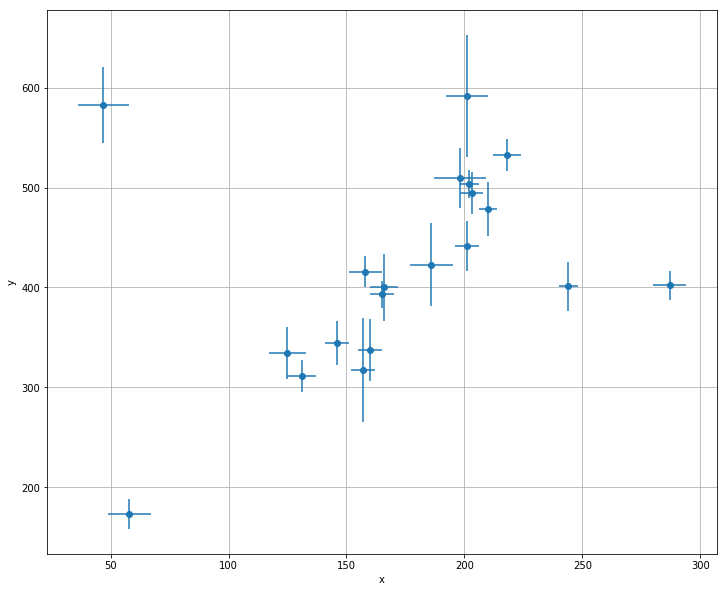

In [84]:
# Plot the data

from matplotlib import pyplot as plt
from IPython.display import display

def plot_data(table):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.errorbar(*table.columns[1:5].values(), fmt='o')
    ax.set(xlabel='x', ylabel='y')
    ax.grid()
    return fig, ax

fig, ax = plot_data(table)
display(fig)

## Standard practice - [Linear regression](https://en.wikipedia.org/wiki/Linear_regression) [sic]
<br>

Standard weighted least-squares fitting is **only** appropriate when:
- there is a dimension along which the data points have negligible uncertainties
- another dimension along which all the uncertainties can be described by Gaussians of known variance

<br>

**NOTE:** These assumptions are very frequently not met in practice!!

<br>

If theses assumptions hold, we want to find a function of the form 

$$ \Large f(x) = mx + b $$
that "*best fits*" the points.  This is typically done by a linear algebra procedure that can be written mathematically as follows:

Given the matrices <br>
$Y = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}$ &emsp; -- The data we are trying to model
<br>
$A = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_n\end{bmatrix}$ -- Coefficient matrix (Independent variables)
<br>
$C = \begin{bmatrix} \sigma^2_{y_1} & 0 & ... & 0 \\
                       0 & \sigma^2_{y_2} & ... & 0 \\
                       & & \ddots \\
                       0 & 0 & ...& \sigma^2_{y_n}\end{bmatrix}$ -- The Covariance matrix (no covariance amongst points)


The best-fit values for the parameters $m$ and $b$ are the components of a column vector

$$\Theta = \begin{bmatrix} b \\ m \end{bmatrix} = \left[ A^T C^{-1} A \right]^{-1} \left[A^T C^{-1} Y \right] $$


This minimized the objective $\chi^2$ objective function which gives the *total squared error* scaled by the uncertainties:


$$\chi^2 = \sum_{i=1}^n \frac{(y_i - f(x_i))^2}{\sigma^2_{y_i}} \equiv \left[Y - A\Theta\right]^T C^{-1} \left[Y - A\Theta\right] $$

 - $\chi^2$ is metric distance in the data space ("Malhanobis distance")


### m = 1.077; b = 213.273

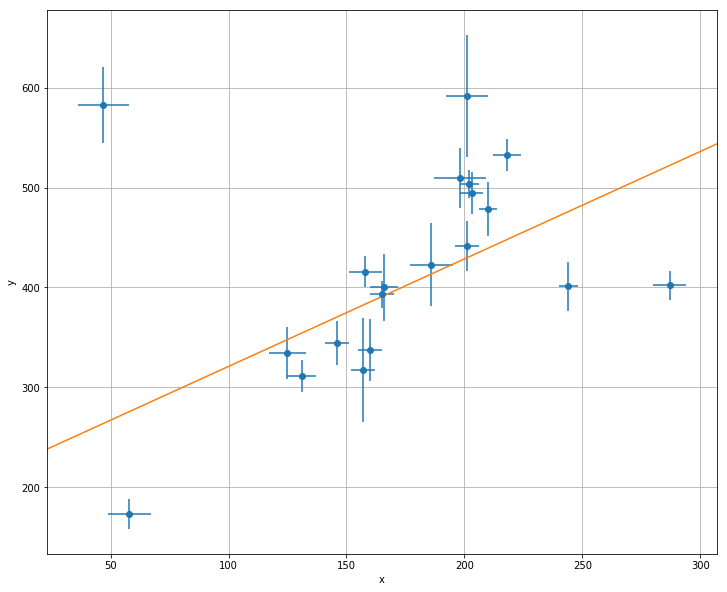

In [96]:
# Lets apply this procedure
# WARNING: THIS IS WRONG - DON'T DO WITH YOUR OWN DATA!!!!!!!!

# We ignore the fact that we have uncertainties in x and correlated uncertainties on each point

import numpy as np
from IPython.display import Markdown

def line(θ, x):
    m, b = θ
    return m * x + b

# define the matrices
x = np.array(table['x'])
y = np.array(table['y'])
σ_y = np.array(table['σ_y'])
A = np.vstack([x, np.ones(len(x))]).T
w = np.diag(1 / σ_y)   # weights

# Weighted least squares full data set
Θ, *_ = np.linalg.lstsq(w @ A, y @ w, rcond=None)

# print parameter values
display(Markdown('### m = {:.3f}; b = {:.3f}'.format(*Θ)))

# plot the results
fig, ax = plot_data(table)
ax.set_autoscale_on(False)
xp = np.linspace(*ax.get_xlim())
ax.plot(xp, line(Θ, xp))
display(fig)

### Partial: m = 2.240; b = 34.048

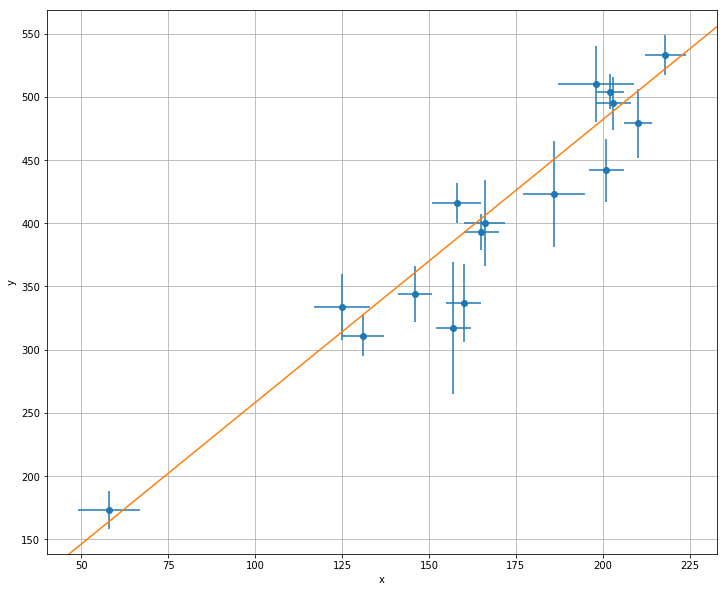

In [91]:
# We can also cheat and ignore some data to get a fit that better represents the underlying trend
# THIS IS SUBJECTIVE - YOU SHOULD NEVER DO THIS IN PRACTICE

# Weighted least squares partial data set (ignoring the first 4 points)
Θ_part, *_ = np.linalg.lstsq(w[4:, 4:] @ A[4:], y[4:] @ w[4:, 4:], rcond=None)

display(Markdown('### Partial: m = {:.3f}; b = {:.3f}'.format(*Θ_part)))
# plot the results
fig, ax = plot_data(table[4:])
ax.set_autoscale_on(False)
xp = np.linspace(*ax.get_xlim())
ax.plot(xp, line(Θ_part, xp))
display(fig)

 ### Objective functions
 
 - I the example above we made a choice of *objective function* using $\chi^2$ to represent "goodness of fit"
 - There are many possible choices, but....
 - The only procedure that is truly justified* is to make a **generative model** for the data.
 - A generative model is a parameterized, quantitative description of a statistical procedure that could reasonably have generated the data
 
 *in the sense that it leads to interpretable probabilistic inference
 

## Generative Models   $\mathscr{M}$
<br>

- If our data really do come from a straight line, and the *only* reason it deviates from the straight line is because some offset (noise) coming from a <br>
Gaussian $\mathscr{N}(0, \sigma_{y_i})$ has been added to each data point $y_i$, then we have the likelihood:
<br>
$$ P(y_i | x_i, \sigma_{y_i}, m, b) = \frac{1}{\sqrt{2\pi} \sigma_{y_i}} \exp \left( -\frac{(y_i - mx_i - b)^2}{2 \sigma^2_{y_i}} \right)$$

- This gives the probability of getting a value for $y_i$ within the infinetesimal interval $[y_i, y_i + dy]$
- This *generative model* provides a natural, justified objective:  
> We seek the line that maximizes the probability of observing the data. --> This is the *Maximum likelihood principle*

<br>
Working with a single data point is not that useful! <br>
In our generative model, each data point is independent of the others, so the total likelihood is the product of likelihoods of individual points
<br>

$$ \mathscr{L} = \prod_{i=1}^n p(y_i | x_i, \sigma_{y_i}, m, b)$$
Taking the logarithm
$$ \ln \mathscr{L} = k - \sum^n_{i=1} \frac{(y_i - mx_i - b)^2}{2 \sigma^2_{y_i}} $$
$$ = k - \frac{1}{2} \chi^2 $$

The last equation shows that the *maximum likelihood* value of our parameters corresponds to the least squares result **under the assumptions above**

## Going Bayesian
<br>

The Bayesian generalization of our likelihood maximization can be written down via [Bayes Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)

$$ P(m, b | \bar{y}, I) = \frac{\mathscr{L}(\bar{y}|m, b, I) P(m, b|I)}{Z(\bar{y}|I)}  $$
Or more succinctly:
$$ P(\Theta | \bar{y}) = \frac{1}{Z} \mathscr{L}(\bar{y}|\Theta) P(\Theta) $$ 

This gives the **posetrior probability distribution** of our model parameters $\Theta = \{m, b\}$ given out data $\bar{y} = \{y_i\}^n_{i=1}$

 - $ \mathscr{L}(\bar{y}|m, b, I) = \mathscr{L}(\bar{y}|\Theta)$  &emsp; is the likelihood as above
 - $ P(m, b|I) = P(\Theta) $ &emsp;&emsp;&emsp;&emsp;  is the *prior distribution* on our parameteres - encodes all current knowledge we have about our parameters
 - $ Z $ &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; is a normalization constant (obtained by integrating the numerator over all parameters)

# Dealing with outliers
<br>

- Our dataset contains some obvious outliers
- Most justifiable way of dealing with these is to expand our generative model to include them
- This is better than pruning outliers by hand - this is subjective and will bias your results

<br>

We think of our data as being drawn from 2 independent superposed Gaussian distributions: [A Gaussian Mixture Model](https://en.wikipedia.org/wiki/Mixture_model)
<br>
&emsp;&emsp; - One represents the straight line (foreground) just as before
<br>
&emsp;&emsp; - The other represents the outliers (background) generated by $\mathscr{N}(\mu_b, \sigma_b)$

Given that there is some probability $\alpha$ that our data is generated by the "bad" distribution (the fraction of bad data),
<br>
the likelihood of our expanded generative model is constructed as:

$$ \mathscr{L} = \prod_{i=1}^n \left((1 - \alpha) p_{fg} + \alpha p_{bg}\right)  $$

where $p_{fg}$ and $p_{bg}$ are the generative models for our straight line and outliers respectively.
<br>
Fully expanded our likelihood is now:

$$ \mathscr{L} = \prod_{i=1}^n \frac{1}{\sqrt{2\pi}} \left[ \frac{1 - \alpha}{\sigma_{y_i}} \exp \left( -\frac{(y_i - mx_i - b)^2}{2 \sigma^2_{y_i}} \right) +
                                \frac{\alpha}{(\sigma_{y_i} + \sigma_b)} \exp \left( -\frac{(y_i - \mu_b)^2}{2 (\sigma^2_{y_i} + \sigma^2_b)} \right) \right ]$$

<br>                                
                                
Our new generative model consists of 5 parameters: $ \Theta = \{m, b, \alpha, \mu_b, \sigma_b \} $


# Using MCMC to sample the posterior distribution
<br>

For computational convenience, we work with the log-likelihood, and ignore the constant multiplier term

$$ \ln \mathscr{L} \propto \sum_{i=1}^n \ln \left[ \frac{1 - \alpha}{\sigma_{y_i}} \exp \left( -\frac{(y_i - mx_i - b)^2}{2 \sigma^2_{y_i}} \right) +
                                \frac{\alpha}{(\sigma_{y_i} + \sigma_b)} \exp \left( -\frac{(y_i - \mu_b)^2}{2 (\sigma^2_{y_i} + \sigma^2_b)} \right) \right ]$$
        
<br> 
We have to choose some prior for our parameters. There are many ways of doing this (which we can't delve into here).  If we know nothing about the distribution of our parameters a good option is to choose uninformative priors: That is distributions that add as little information as possible.



In [188]:
from scipy.stats.distributions import norm, uniform, reciprocal as loguniform
import multiprocessing as mp
import emcee


# choose priors
priors = dict(
    m_prior=uniform(0, 10),
    b_prior=uniform(0, 1e3),
    α_prior=uniform(0, 1),
    μ_prior=uniform(0, 1e3),
    σ_prior=loguniform(1e-2, 1e3)
)


def ln_prior(Θ):
    return sum([np.log(prior.pdf(p)) 
                for prior, p in zip(priors.values(), Θ)])

def gaussian_pdf(y, μ, σ):
    return np.exp(-0.5 * np.square((y - μ) / σ)) / σ


def ln_likelihood(Θ, x, y, σy):
    Θfg = Θ[:2]
    Θbg = (α, μb, σb) = Θ[2:]
    σ = np.sqrt(σy * σy + σb * σb)  # stddev of our outlier generator
    ll = np.sum(np.log(((1 - α) / σy) * gaussian_pdf(y, line(Θfg, x), σy) +
                       (α / (σy + σb)) * gaussian_pdf(y, μb, σ)))
    if not np.isfinite(ll):
        return -np.inf
    return ll


def ln_posterior(Θ, x, y, σy):
    return ln_prior(Θ) + ln_likelihood(Θ, x, y, σy)


dof = len(priors)  # degrees of freedom
n_walkers_per_dof = 4   # this is a good rule of thumb
n_walkers = dof * n_walkers_per_dof
n_threads = int(mp.cpu_count())

# create sampler
sampler = emcee.EnsembleSampler(n_walkers, dof, ln_posterior,
                                args=(x, y, σ_y), threads=n_threads)

# randomized initial guesses for parameters
p0 = np.random.rand(n_walkers, dof)
#p0 = np.array([param.rvs(n_walkers) for param in priors.values()]).T

# burn in
n_burn = 1e3
pos, prob, state = sampler.run_mcmc(p0, n_burn)
sampler.reset()

# sample posterior
n_samples = 1e5
pos, prob, state = sampler.run_mcmc(p0, n_samples)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log


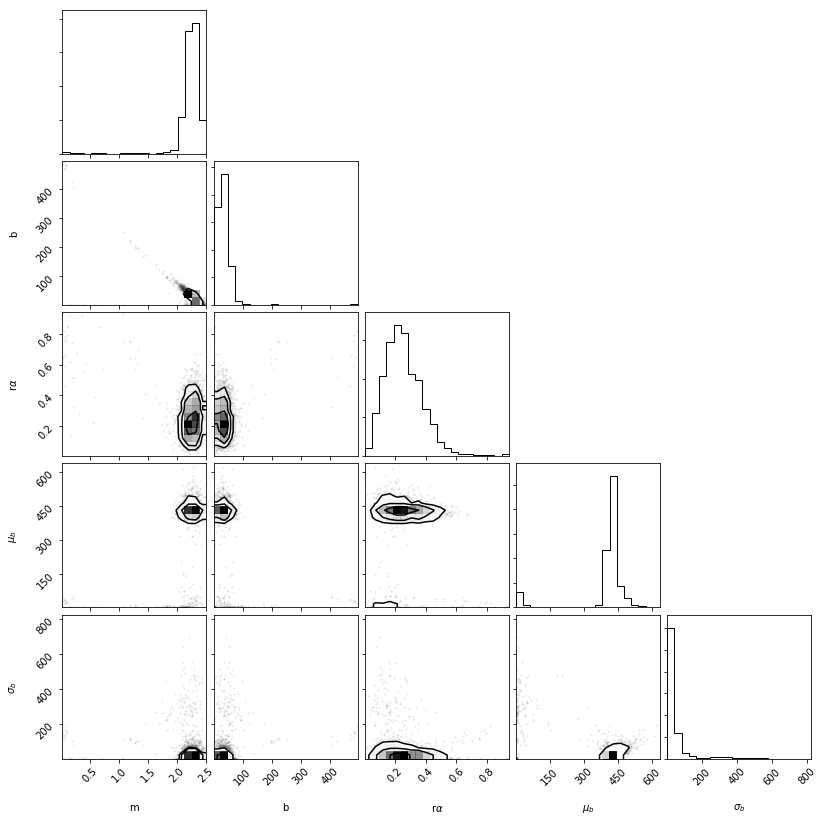

In [198]:
import corner

# get the samples
flat_samples = sampler.chain.reshape(-1, dof)[::100]
labels = 'm','b',r'r$\alpha$',r'$\mu_b$',r'$\sigma_b$'

# plot the posteriors
fig = corner.corner(flat_samples, labels=labels)
display(fig)

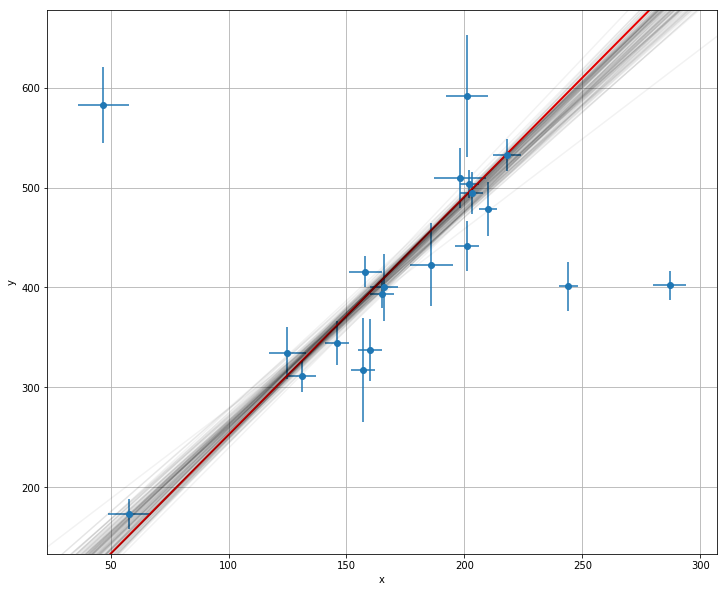

In [224]:
# plot the Maximum a-posteriori line

from scipy.stats import mode

fig, ax = plot_data(table)
m_b = flat_samples[:, :2]
pmap = mode(m_b, 0).mode[0]

ax.set_autoscale_on(False)
xp = np.linspace(*ax.get_xlim())
ax.plot(xp, line(pmap, xp), 'r', lw=2)

# plot some random samples from the posterior
i = np.random.randint(0, n_samples, 100)
for m, b in m_b[i]:
    ax.plot(xp, line((m, b), xp), 'k', alpha=0.05)

display(fig)

# Additional Resources
<br>

### Review Papers
1. [Data analysis recipes: Fitting a model to data](https://ui.adsabs.harvard.edu/abs/2010arXiv1008.4686H/abstract) <br>Hogg+ (2010)
2. [Data Analysis Recipes: Using Markov Chain Monte Carlo](https://ui.adsabs.harvard.edu/abs/2018ApJS..236...11H/abstract)<br>Hogg & Foreman-Mackey (2018)
3. [Bayes in the sky: Bayesian inference and model selection in cosmology](https://ui.adsabs.harvard.edu/abs/2008ConPh..49...71T/abstract) <br> Trotta (2008)

<br>

### Tutorials
1. [emcee](https://emcee.readthedocs.io/en/stable/tutorials/line/)

<br>

### Textbooks
1. [Probabilistic Programming & Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)


<br>

### Talks

1. [All About that Bayes: Probability, Statistics, and the Quest to Quantify Uncertainty](https://www.youtube.com/watch?v=eDMGDhyDxuY) <br> Kristin Lennox